In [34]:
import csv
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional,SimpleRNN
import nltk
import string
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
df = pd.read_csv('/content/bbc-text.csv')

In [37]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


# Text Data PreProcessing

In [38]:
def data_cleaning(data):

  data = data.lower()
  data = re.sub('[^a-zA-z0-9]',' ', data)
  data = [words for words in data.split() if words not in STOPWORDS]

  return " ".join(data)


In [39]:
df['text'] = df['text'].apply(lambda x : data_cleaning(x))

In [40]:
df.head()

,category,text
0,tech,tv future hands viewers home theatre systems p...
1,business,worldcom boss left books alone former worldcom...
2,sport,tigers wary farrell gamble leicester say rushe...
3,sport,yeading face newcastle fa cup premiership side...
4,entertainment,ocean twelve raids box office ocean twelve cri...


# Assign Constants

In [66]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
oov_tok = '<OOV>'
training_portion = 0.8

# Labels Encoding

In [68]:
from sklearn.preprocessing import LabelEncoder

Encoder = LabelEncoder()
y = Encoder.fit_transform(df['category'])

# Text Tokenization + Padding

In [74]:
tokinizer = Tokenizer(num_words=vocab_size , oov_token= oov_tok)
tokinizer.fit_on_texts(df['text'])
sequences = tokinizer.texts_to_sequences(df['text'])
padded_seq = pad_sequences(sequences , maxlen=max_length)

# Train Test Split

In [86]:
padded_seq.shape

(2225, 200)

In [79]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(padded_seq, y, test_size=0.2, random_state= 42,)

In [90]:
len(x_train)

1780

# Model Bulid

In [91]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_dim, input_length=len(x_train)))
model.add(Dropout(0.2))

# first RNN Layer

model.add(SimpleRNN(units=embedding_dim , return_sequences=True))
model.add(Dropout(0.2))

# second RNN Layer

model.add(SimpleRNN(units=embedding_dim))
model.add(Dropout(0.2))

# add Dense Layer

model.add(Dense(64 , activation='relu'))
model.add(Dropout(0.2))

# add output layer

model.add(Dense(5 , activation='softmax'))

In [99]:
padded_seq.shape[1]

200

In [98]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padded_seq.shape[1]))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=embedding_dim, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=embedding_dim))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the model manually (ده مهم لما تستخدم model.summary())
model.build(input_shape=(None, input_length))

# Show the model
model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 200, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_16 (SimpleRNN)       │ (None, 200, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_17 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 340,997 (1.30 MB)

 Trainable params: 340,997 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [100]:
history = model.fit(x_train , y_train , epochs=20 , validation_data=(x_test , y_test), batch_size=32)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.2153 - loss: 1.6445 - val_accuracy: 0.2562 - val_loss: 1.5982
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.2537 - loss: 1.5971 - val_accuracy: 0.2607 - val_loss: 1.5846
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.3483 - loss: 1.5045 - val_accuracy: 0.4517 - val_loss: 1.2928
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.6620 - loss: 0.9479 - val_accuracy: 0.5483 - val_loss: 1.1743
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.9037 - loss: 0.3439 - val_accuracy: 0.6225 - val_loss: 1.1375
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.9890 - loss: 0.0785 - val_accuracy: 0.6427 - val_loss: 1.2101
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.9982 - loss: 0.0273 - val_accuracy: 0.6966 - val_loss: 1.2557
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9962 - loss: 0.0182 - val_accurac

# Visualize Accuracy

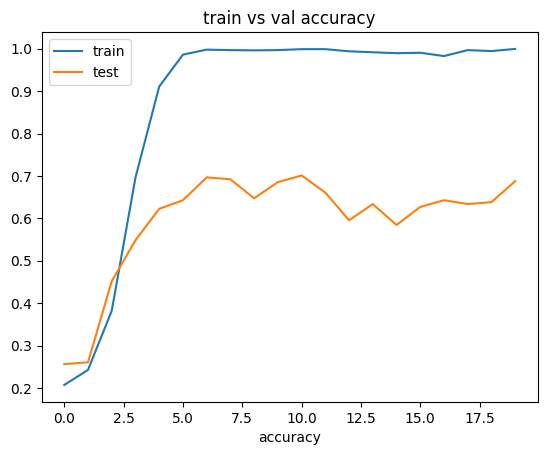

In [104]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("train vs val accuracy")
plt.xlabel('epochs')
plt.xlabel('accuracy')
plt.legend(['train' , 'test'])
plt.show()

# classification report

In [106]:
from sklearn.metrics import classification_report , confusion_matrix

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=Encoder.classes_))


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
               precision    recall  f1-score   support

     business       0.57      0.84      0.68       101
entertainment       0.75      0.74      0.75        81
     politics       0.71      0.48      0.58        83
        sport       0.86      0.95      0.90        98
         tech       0.55      0.34      0.42        82

     accuracy                           0.69       445
    macro avg       0.69      0.67      0.66       445
 weighted avg       0.69      0.69      0.67       445



In [107]:
import seaborn as sns

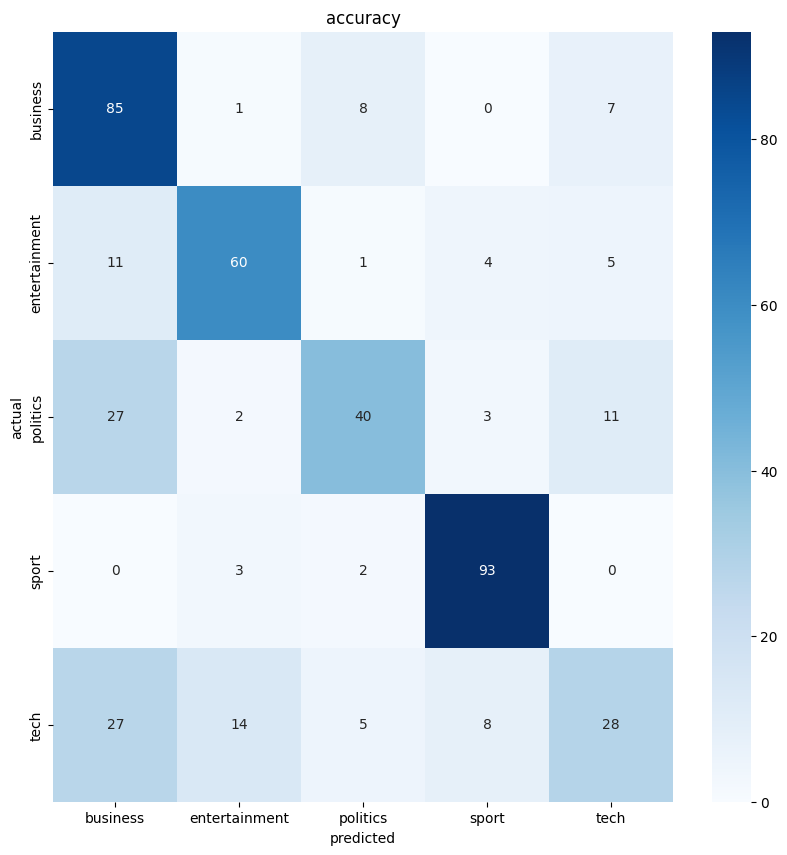

In [109]:
cm = confusion_matrix(y_test , y_pred_classes)
plt.figure(figsize = (10,10))

sns.heatmap(cm , annot = True , cmap='Blues' , xticklabels=Encoder.classes_ , yticklabels= Encoder.classes_)

plt.title('accuracy')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

In [112]:
txt = ["blair prepares to name poll date tony blair is likely to name 5 may as election day when parliament returns from its easter break  the bbc s political editor has learned.  andrew marr says mr blair will ask the queen on 4 or 5 april to dissolve parliament at the end of that week. mr blair has so far resisted calls for him to name the day but all parties have stepped up campaigning recently. downing street would not be drawn on the claim  saying election timing was a matter for the prime minister.  a number 10 spokeswoman would only say:  he will announce an election when he wants to announce an election.  the move will signal a frantic week at westminster as the government is likely to try to get key legislation through parliament. the government needs its finance bill  covering the budget plans  to be passed before the commons closes for business at the end of the session on 7 april.  but it will also seek to push through its serious and organised crime bill and id cards bill. mr marr said on wednesday s today programme:  there s almost nobody at a senior level inside the government or in parliament itself who doesn t expect the election to be called on 4 or 5 april.  as soon as the commons is back after the short easter recess  tony blair whips up to the palace  asks the queen to dissolve parliament ... and we re going.  the labour government officially has until june 2006 to hold general election  but in recent years governments have favoured four-year terms."]

seq = tokinizer.texts_to_sequences(txt)
padded = pad_sequences(seq , maxlen=max_length)

labels = ['bussiness', 'entertainment', 'politics', 'sport', 'tech']

pred = model.predict(padded)

print(np.argmax(pred))
print(labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2
politics
